In [7]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import diverging_palette

import sklearn
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

from sklearn.linear_model import (
    LogisticRegression,
    Lasso
)

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    RepeatedStratifiedKFold,
    GridSearchCV,
    KFold,
    StratifiedKFold
)

from sklearn.metrics import (
    accuracy_score, 
    precision_score, average_precision_score,
    precision_recall_curve,
    confusion_matrix, plot_confusion_matrix,
    roc_curve, roc_auc_score,
    classification_report,
    make_scorer, fbeta_score
)

import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance

from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)
from yellowbrick.model_selection import LearningCurve

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=ConvergenceWarning)

# Load Dataset into DataFrame

In [8]:
url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Airline-Passenger-Satisfaction-Prediction/main/Data/df5.csv'
data = pd.read_csv(url)
data

,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,...,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
0,26.0,0.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,...,3.0,4.0,4.0,4.0,5.0,0.0,1.0,0.0,1.0,1.0
1,61.0,0.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,...,4.0,4.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0
2,47.0,2.0,1276.0,2.0,4.0,2.0,3.0,2.0,2.0,2.0,...,3.0,4.0,3.0,5.0,2.0,9.0,0.0,1.0,1.0,0.0
3,52.0,0.0,2035.0,4.0,3.0,4.0,4.0,5.0,5.0,5.0,...,5.0,5.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,1.0
4,20.0,2.0,1061.0,3.0,3.0,3.0,4.0,2.0,3.0,3.0,...,3.0,4.0,4.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43954,26.0,0.0,712.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,...,4.0,4.0,3.0,4.0,5.0,17.0,1.0,1.0,1.0,1.0
43955,57.0,2.0,867.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,...,4.0,3.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,1.0
43956,60.0,0.0,1599.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,...,4.0,4.0,4.0,4.0,4.0,9.0,1.0,0.0,1.0,1.0
43957,50.0,2.0,1620.0,3.0,1.0,3.0,4.0,2.0,3.0,2.0,...,3.0,4.0,2.0,4.0,2.0,0.0,0.0,1.0,1.0,0.0


# Data Preparation

## Standardization of numeric variables

In [9]:
numeric_cols = ['Age', 'Flight_Distance','Departure_Delay_in_Minutes']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

## Handling Missing values

The satisfaction level of each feature should range from 1 to 5. 

If the rating is 0, that means the customer did not rate for this feature.


In [10]:
def list_column_values(df, number_of_values, print_all):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() <= number_of_values:
            print(f"{col.ljust(25)}" +  ' ==> ' + str(df[col].sort_values().unique().tolist()) )
        else:  
            if print_all=='True':
               print(f"{col.ljust(25)}" + ' ==> more than ' + str(number_of_values) + ' values')

In [11]:
list_column_values(data, data.shape[1],'True')

**Results:**

Age                       ==> more than 22 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 22 values
Inflight_wifi_service     ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more t

In [12]:
incomplete = ['Inflight_wifi_service','Departure/Arrival_time_convenient',
              'Ease_of_Online_booking','Online_boarding','Leg_room_service']
(data[incomplete] == 0).sum()

Inflight_wifi_service                 67
Departure/Arrival_time_convenient    134
Ease_of_Online_booking                58
Online_boarding                       16
Leg_room_service                       1
dtype: int64

In [13]:
(data[incomplete] == 0).sum().sum()/data.shape[0]

0.00627857776564526

We should consider rating=0 as missing values as the customer did not provide any rating feedback.

Considering the total number of rows that contains missing ratings only takes up 0.6% of the dataset, we simply drop these observations.

In [14]:
data = data.loc[(data[incomplete] != 0).all(axis=1)]

list_column_values(data, data.shape[1],'True')

**Results:**

Age                       ==> more than 22 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 22 values
Inflight_wifi_service     ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more than 22 values
satisfactio

In [15]:
data.shape

(43756, 22)

# Splitting the Dataset

Identify features and target

In [16]:
X = data.drop(columns=['satisfaction'])
y = data['satisfaction']

## Train Test Split

In [17]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

N_train, _ = X_train.shape 
N_val_test,  _ = X_val_test.shape 

N_train, N_val_test

(35004, 8752)

## Test Validation Split

In [18]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 777)

N_val, _ = X_val.shape 
N_test,  _ = X_test.shape 

N_val, N_test

(4376, 4376)

In [19]:
data.columns

Index(['Age', 'Class', 'Flight_Distance', 'Inflight_wifi_service',
       'Departure/Arrival_time_convenient', 'Ease_of_Online_booking',
       'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment', 'On-board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Inflight_service',
       'Cleanliness', 'Departure_Delay_in_Minutes', 'satisfaction',
       'Gender_Male', 'Customer_Type_Loyal Customer',
       'Type_of_Travel_Business travel'],
      dtype='object')

# Functions for Evaluation Metrics

### ROC Curve

In [20]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### PR Curve

In [21]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

### Classification Score

It gets the model and evaluates it for training and validation.

In [22]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        plot_confusion_matrix(clf,  X_val, clf.predict(X_val))
        print("End of validation Result\n")

### Model Results Comparison

In [23]:
model_comparison = pd.DataFrame(columns=['precision','recall','f1-score','support'])

def add_result(model_name, y_actual, y_pred):
    global model_comparison

    report = classification_report(y_actual, y_pred, output_dict=True)
    scores = pd.DataFrame(report['1.0'],index=[model_name])

    model_comparison = model_comparison.append(scores)
    
    print(model_comparison)

# Verify Class Balance

In [24]:
data['satisfaction'].value_counts()

1.0    23925
0.0    19831
Name: satisfaction, dtype: int64

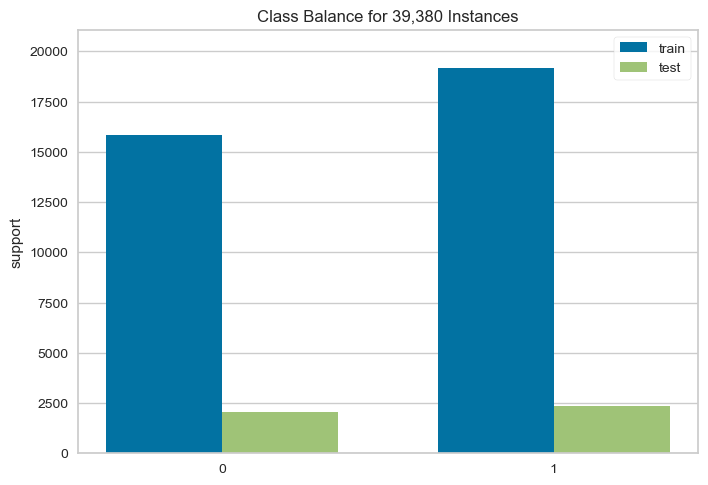

<AxesSubplot:title={'center':'Class Balance for 39,380 Instances'}, ylabel='support'>

In [25]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Modelling

Baseline Model - DummyClassifier ✔

==========================

Feature Selection 
- LASSO (prefered)
- RFE

==========================

- Logistics Regression
- KNN
- Gaussian (Naive Bayees)

- Decision Tree
- Random Forest

- LightGBM
- XGBoost
- AdsBoost


## Baseline Model - DummyClassifier

In [26]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train,y_train)

DummyClassifier()

Validation Result:

accuracy score: 0.5359



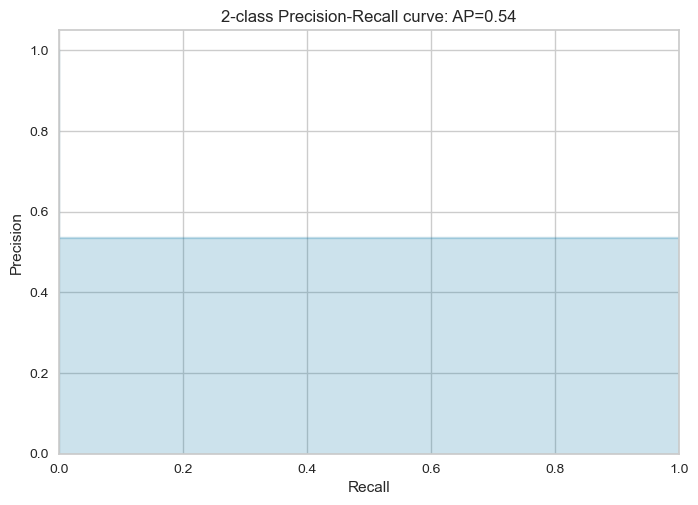

roc auc score: 0.5



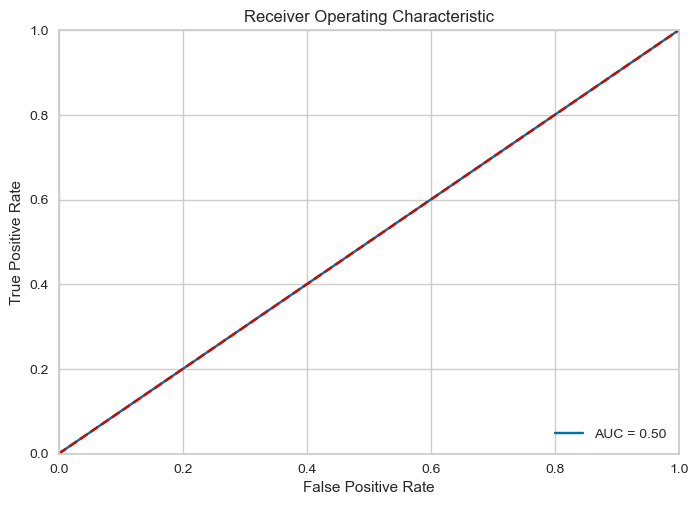

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2031
         1.0       0.54      1.00      0.70      2345

    accuracy                           0.54      4376
   macro avg       0.27      0.50      0.35      4376
weighted avg       0.29      0.54      0.37      4376


Confusion Matrix: 
 [[   0 2031]
 [   0 2345]]

End of validation Result



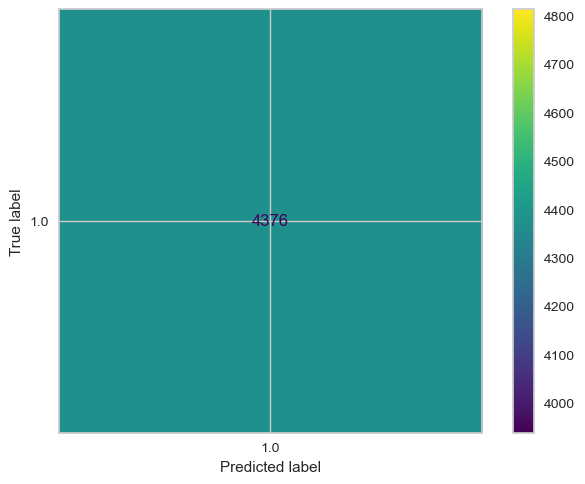

In [27]:
clf_score(dummy, X_train, y_train, X_val, y_val, train=False)

In [28]:
# Add result to model_comparison dataframe
model_name = 'DummyClassifier'
y_pred = dummy.predict(X_val)

add_result(model_name, y_val, y_pred)

                 precision  recall  f1-score support
DummyClassifier   0.535878     1.0  0.697813    2345


## Feature Selection

### 1. LASSO

In [29]:
lasso = Lasso(alpha=0.01)
model_lasso = lasso.fit(X_train, y_train)

In [30]:
model_lasso.coef_

array([ 0.00044513, -0.13973791,  0.01361016,  0.        , -0.00894538,
        0.        ,  0.00582552, -0.        ,  0.09717539,  0.03391091,
        0.0275149 ,  0.04385917,  0.03912013,  0.02210841,  0.03506695,
        0.01830838,  0.02908356, -0.00350892,  0.        ,  0.08976133,
        0.20718092])

In [31]:
pd.DataFrame(list(zip(X_train.columns,abs(model_lasso.coef_))), columns = ['predictor','coefficient']).sort_values(by='coefficient')

,predictor,coefficient
18,Gender_Male,0.000000
3,Inflight_wifi_service,0.000000
5,Ease_of_Online_booking,0.000000
7,Food_and_drink,0.000000
0,Age,0.000445
17,Departure_Delay_in_Minutes,0.003509
6,Gate_location,0.005826
4,Departure/Arrival_time_convenient,0.008945
2,Flight_Distance,0.013610
15,Inflight_service,0.018308


### 2. RFE

In [32]:
from sklearn.feature_selection import RFE

lr = LogisticRegression(max_iter=5000)
rfe = RFE(lr, n_features_to_select=3) 
model_rfe = rfe.fit(X_train,y_train)

In [33]:
model_rfe.support_

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True])

In [34]:
pd.DataFrame(list(zip(X_train.columns,model_rfe.ranking_)), 
             columns = ['predictor','ranking']).sort_values(by='ranking')

,predictor,ranking
10,Inflight_entertainment,1
19,Customer_Type_Loyal Customer,1
20,Type_of_Travel_Business travel,1
8,Online_boarding,2
1,Class,3
13,Baggage_handling,4
14,Checkin_service,5
11,On-board_service,6
16,Cleanliness,7
9,Seat_comfort,8


Based on the above results, we can drop 'Gender_Male','Gate_location','Age', 'Food_and_drink'. 

In [35]:
X_train = X_train.drop(columns=['Gender_Male', 'Gate_location', 'Food_and_drink', 'Age'])
X_val = X_val.drop(columns=['Gender_Male', 'Gate_location', 'Food_and_drink', 'Age'])

## LightGBM

### Model Tuning

In [36]:
LGB = lgb.LGBMClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
params = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.1],
    'num_leaves': [10, 30, 50],
    'max_depth': [3, 5, 7]
}

scoring = make_scorer(fbeta_score, beta=2)
grid_search_lgb = GridSearchCV(estimator=LGB, param_grid=params, scoring=scoring, cv=kfold)
grid_search_lgb.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Print out the tunning result
print(grid_search_lgb.best_score_)

In [ ]:
# Print out the tunning parameters
print(grid_search_lgb.best_params_)

## hyperopt hyperparameters tuning

In [38]:
!pip install hyperopt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [61]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Redefine the function with a wider range of hyperparameters
def objective(search_space):
    lgbm_clf = LGBMClassifier(n_estimators=50,
                          n_jobs=1,
                          learning_rate=0.02,
                          num_leaves=50,
                          max_depth=7,
                          verbose=-1,
                          random_state=42)
    lgbm_clf.fit(X_train, y_train)
    y_pred = lgbm_clf.predict(X_val)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Update the search space
search_space = {'n_estimators': hp.randint('n_estimators', 200, 1000),
               'max_depth': hp.randint('max_depth', 1, 8),
               'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
               'num_leaves': hp.randint('num_leaves', 30, 100),
               'n_jobs': -1,
               'verbose': -1,
               'random_state': 42}

# Set the hyperparameter tuning algorithm
algorithm = tpe.suggest

# Implement Hyperopt
best_params = fmin(fn=objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=200)


100%|██████████| 200/200 [01:23<00:00,  2.39trial/s, best loss: -0.4961151736745887]


In [62]:
space_eval(search_space, best_params)

{'learning_rate': 0.09777395898190361,
 'max_depth': 5,
 'n_estimators': 652,
 'n_jobs': -1,
 'num_leaves': 44,
 'random_state': 42,
 'verbose': -1}

### Build Model

In [57]:
lgbm_clf = LGBMClassifier(n_estimators=791,
                          n_jobs=-1,
                          learning_rate=0.08514793658801519,
                          num_leaves=82,
                          max_depth=3,
                          verbose=-1,
                          random_state=42)
model_lgbm= lgbm_clf.fit(X_train, y_train)
model_name = 'LightGBM'
y_pred = model_lgbm.predict(X_val)

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: max_features


### Learning Curve (check overfitting)

In [58]:
X_train_small = X_train.iloc[:200,]
y_train_small = y_train.iloc[:200]

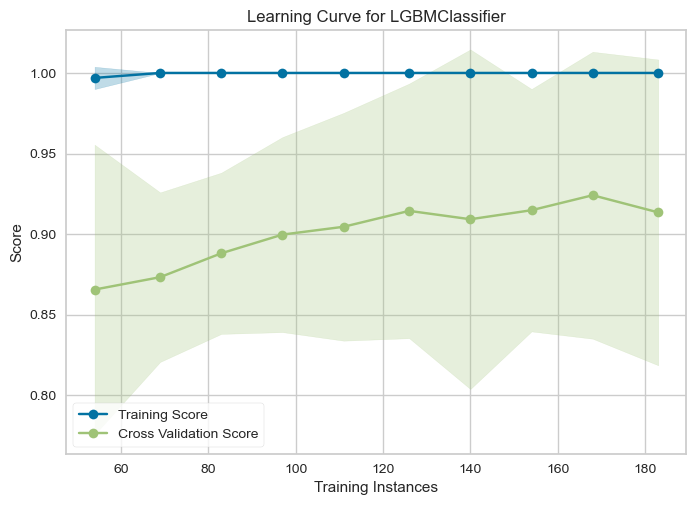

<AxesSubplot:title={'center':'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [59]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer

visualizer = LearningCurve(
    model_lgbm, 
    cv=cv, 
    scoring='f1_weighted', 
    train_sizes=sizes, 
    n_jobs=8
)

visualizer.fit(X_train_small, y_train_small)        # Fit the data to the visualizer
visualizer.poof() 

`Not overfitted now because we have already adjusted the parameters to reduce overfitting.`

### Performance

Validation Result:

accuracy score: 0.9749



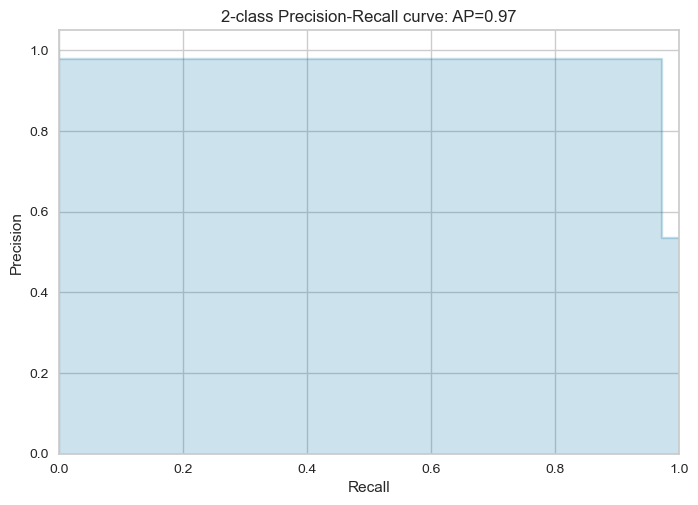

roc auc score: 0.9749965093292768



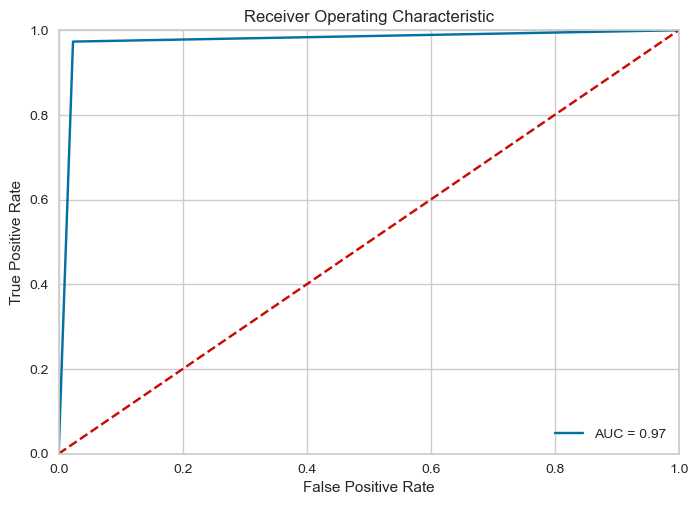

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2031
         1.0       0.98      0.97      0.98      2345

    accuracy                           0.97      4376
   macro avg       0.97      0.97      0.97      4376
weighted avg       0.97      0.97      0.97      4376


Confusion Matrix: 
 [[1984   47]
 [  63 2282]]

End of validation Result



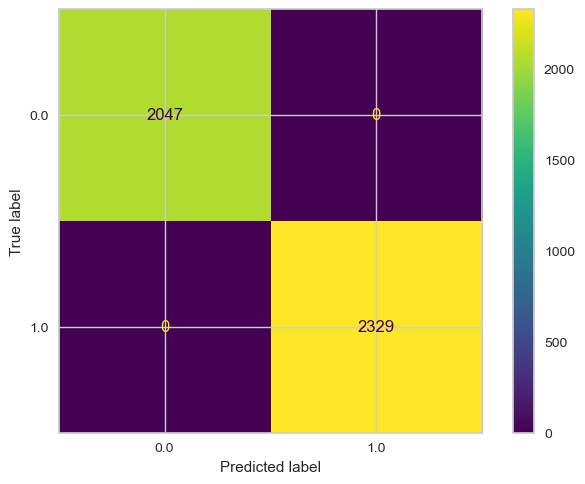

In [60]:
clf_score(model_lgbm, X_train, y_train, X_val, y_val, train=False)

In [37]:
# Add result to model_comparison dataframe
add_result(model_name, y_val, y_pred)

                precision    recall  f1-score support
DummyClassifier  0.535878       1.0  0.697813    2345
LightGBM         0.944604  0.981663  0.962777    2345


In [38]:
model_comparison.to_csv('model_comparison.csv')

### Feature Importance

In [39]:
df_feature_importance = pd.DataFrame({'importance':model_lgbm.feature_importances_, 'feature': X_train.columns.values})
df_feature_importance.sort_values(by = 'importance', ascending=False)

,importance,feature
2,297,Inflight_wifi_service
15,231,Customer_Type_Loyal Customer
11,228,Checkin_service
6,218,Seat_comfort
12,184,Inflight_service
10,179,Baggage_handling
5,163,Online_boarding
16,159,Type_of_Travel_Business travel
7,141,Inflight_entertainment
9,117,Leg_room_service


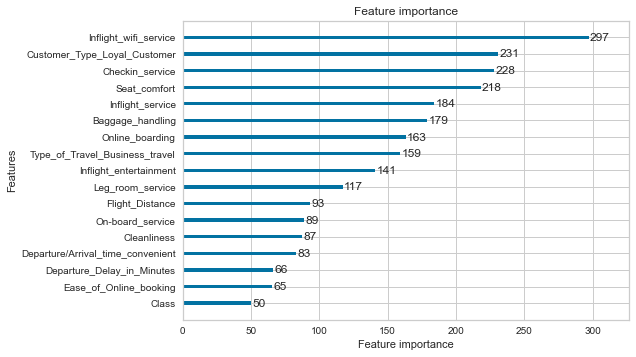

In [40]:
lgb.plot_importance(model_lgbm)
plt.rcParams['figure.figsize'] = [22, 6]
plt.show()